In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rdm
from scipy import integrate, signal, optimize
from matplotlib import gridspec
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Figure 4A

Defining Coupled ODEs

In [17]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**2) # regulatory function for k_n
f_prime = lambda a: -2*a/a_n**2 / (1 + (a/a_n)**2)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**2 / (1 + (a/a_t)**2) # regulatory function for k_t
g_prime = lambda a: 2*a/a_t**2 / (1 + (a/a_t)**2)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: (-f_prime(a)*g(a)*phiR_max + f(a)*g_prime(a)*phiR_min) / (-f_prime(a)*g(a) + f(a)*g_prime(a))

# f_X, fraction of cell synthesis capacity devoted to division protein production
f_X = lambda a: alpha*(phiR_max - f_R(a)) + beta

In [18]:
# ribosome mass fraction ODE (f_R variable)

def dphiR_dt(phi_R, t, a):

    k_t = k_t0 * g(a) # translational efficiency

    dpdt = k_t * (phi_R - phiR_min) * (f_R(a) - phi_R)
    return dpdt

In [19]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R, t_feast):

    k_n = k_n0(t, t_feast) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - k_t * (phi_R - phiR_min) + mu_ns
    return dadt

In [20]:
# defining growth rate function

def GrowthRate(a, phi_R):

    k_t = k_t0 * g(a)

    k = k_t * (phi_R - phiR_min) - mu_ns
    return k

Calculating steady state values

In [21]:
# function for phi_R at steady state

def phiR_ss(a, t_feast):

    k_n = k_n0(t_min,t_feast) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return (k_n*phiR_max + k_t*phiR_min + mu_ns) / (k_n + k_t)

In [22]:
# function for calculating steady state conditions for given parameters

def func(x, t_feast):
    return [phiR_ss(x[0], t_feast) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

Defining Model

In [23]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, t_feast):

    phi_R,a = Species # Tuple unpacking of each species, equivalent to phi_R = Species[0] // a = Species[1]

    phiR_ode = dphiR_dt(phi_R, t, a)
    a_ode = dAAdt(a, t, phi_R, t_feast)

    dSpeciesdt = [phiR_ode,a_ode]
    return dSpeciesdt

In [24]:
def model(t, t_feast):

    # calculating initial conditions
    argtuple = (t_feast,)
    root = optimize.fsolve(func, [1e-4, 0.4], args=argtuple) # requires an initial guess
    species_0 = [root[1],root[0]] # [phi_R0,a0]

    species = integrate.odeint(odes, species_0, t, args=argtuple) #numerically solving coupled ODEs

    phi_R = species[:,0]
    a = species[:,1]

    kappa = GrowthRate(a, phi_R)

    return kappa

In [28]:
# parameters

t_min = -2
t_max = 6
t_shift = 0

n_f = 2
n_g = 2

phiR_min = 0.049 # Scott et al. 2010
phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

k_t0 = 2.6
kn0_high = 62.8
kn0_low = 5.29

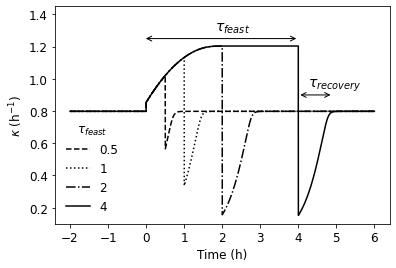

In [27]:
t_shift = 0 # time at which nutrient shift occurs, in hrs
t_feast = [0.5,1,2,4]
t = np.linspace(t_min,t_max,10000)
k_n0 = lambda t, t_feast: (kn0_high - kn0_low) * (np.heaviside(t-t_shift,0.5) - np.heaviside(t-(t_shift+t_feast),0.5)) + kn0_low
mu_ns = 0

lines = ['--',':','-.','-']
fig = plt.figure()
plt.rc('font', size=12) #controls default text size
i = 0
for x in t_feast:

    plt.plot(t, model(t, x), label=x, color='k', linestyle=lines[i])
    i+=1
plt.xlabel('Time (h)')
plt.ylabel('$\kappa$ (h$^{-1}$)')
plt.legend(title='$\u03C4_{feast}$', loc='lower left', frameon=False)

# plotting t_feast arrow
plt.annotate('$\u03C4_{feast}$', xy=(1.8,1.3), size=14)
plt.annotate("",
        xy=(-0.06, 1.25), xycoords='data',
        xytext=(4, 1.25), textcoords='data',
        arrowprops=dict(arrowstyle="<->",
                        connectionstyle="arc3"),
        )

# plotting t_stable arrow
plt.annotate('$\u03C4_{recovery}$', xy=(4.25,0.95), size=14)
plt.annotate("",
        xy=(4, 0.9), xycoords='data',
        xytext=(4.9, 0.9), textcoords='data',
        arrowprops=dict(arrowstyle="<->",
                        connectionstyle="arc3"),
        )
plt.ylim(0.1,1.45)
plt.show()

### Figure 4D

In [31]:
def simulate(t, t_feast):

    # calculating initial conditions
    argtuple = (t_feast,)
    root = optimize.fsolve(func, initial, args=argtuple) # requires an initial guess
    species_0 = [root[1],root[0]] # [phi_R0,a0]

    species = integrate.odeint(odes, species_0, t, args=argtuple) #numerically solving coupled ODEs

    phi_R = species[:,0]
    a = species[:,1]

    return GrowthRate(a, phi_R), t, GrowthRate(root[0], root[1])

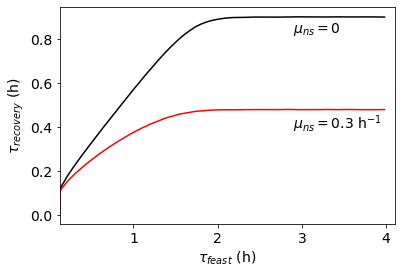

In [32]:
# Stabilization time

mu = [0, 0.3]
init_0 = [[9e-05, 0.39], [6e-05, 0.35]] # initial guesses for each case, bug makes simulations very sensitive to initial guesses
init_2 = [[1e-5, 0.4], [1e-4, 0.42]]
init_1 = [[1e-6, 0.3], [1e-4, 0.42]]

simulation_min = -2
simulation_max = 10
t_shift = 0
n_points = 10000 #number of simulation points
# concentration function
k_n0 = lambda t, t_feast: (kn0_high - kn0_low) * (np.heaviside(t-t_shift,0.5) - np.heaviside(t-(t_shift+t_feast),0.5)) + kn0_low

t_feast = np.logspace(-2,0.6,160)

fig = plt.figure()
plt.rc('font', size=14) #controls default text size

n = 0
color = ['k','r']
for y in mu:
    mu_ns = y
    t_stable = np.zeros(len(t_feast))
    i = 0
    for x in t_feast:

        t = np.linspace(simulation_min,simulation_max,n_points)

        if x < 1 and x > 0.4:
            initial = init_2[n]
        elif x < 0.4:
            initial = init_1[n]
        else:
            initial = init_0[n]

        # simulating growth rate
        kappa, Time, kappa_stable = simulate(t, x) # also returns starting steady state growth rate

        # calculating stabilization time
        t_start = t_shift + x # time of downshift at end of nutrient pulse

        # calculating slope of growth rate (because of undershoot slope should be positive)
        kappa_slope = np.zeros(len(kappa))
        l = 1
        while l < len(kappa):
            kappa_slope[l] = kappa[l] - kappa[l-1]
            l+=1

        index_stable, = np.where((kappa >= kappa_stable*0.995) & (kappa_slope >= 0)) # finding index of growth rate values which were within 1% of the calculated stabilized value 
        index_time, = np.where(Time >= t_start) # finding index corresponding to t_start
        index_stable = index_stable[index_stable > index_time[0]] # only considering growth rates that occur after downshift

        t_stable[i] = Time[index_stable[0]] - t_start # calculating stabilization time
        i+=1
    plt.plot(t_feast, t_stable, color=color[n])
    n+=1
plt.xlabel('$\u03C4_{feast}$ (h)')
plt.ylabel('$\u03C4_{recovery}$ (h)')
plt.annotate('$\mu_{ns}=0$', xy=(2.9,0.83))
plt.annotate('$\mu_{ns}=0.3$ h$^{-1}$', xy=(2.9,0.39))
plt.xlim(0.125,4.1)
plt.show()

#### Simulating multiple trajectories

In [ ]:
# Script to simulate multiple single cell trajectories to assess size control behavior.
# Example analysis is shown for t_feast=0.75h, and was repeated for t_feast=0.5,1,2,4.

In [33]:
# plot function

def PlotGrowth(V, Time):

    # Plot Layout
    plt.figure(figsize=(10,5))
    plt.plot(Time, V)
    plt.xlabel('Time (hr)')
    plt.ylabel('Cell Volume ($\mu m^3$)')

In [ ]:
# simulation implementation

def SimulateAndPlot(simulation_max, iterations, replicates):

    t = np.linspace(simulation_min,simulation_max,iterations)

    V = np.zeros((iterations,replicates))
    V_0 = np.zeros((iterations,replicates)) # birth volume
    delta_V = np.zeros((iterations,replicates))
    tau = np.zeros((iterations,replicates))

    m=0
    while m < replicates:
        cycle_t = np.log(2) / kappa(a0, phi_R0)
        start_t = rdm.randint(0,int(cycle_t*100))/100 # assigning random initial cell volume, in um^3
        birth_size = 1 / f_X(a0) # average cell size at birth at initial steady-state growth
        V[0,m] = birth_size * np.exp(kappa(a0, phi_R0) * start_t)
        V_0[0,m] = V[0,m]

        phi_R = np.zeros((iterations,1))
        phi_R[0] = phi_R0

        a = np.zeros((iterations,1))
        a[0] = a0

        X = np.zeros((iterations,1))
        X[0] = f_X(a0) * birth_size * (np.exp(kappa(a0, phi_R0) * start_t) - 1)

        V_divide = V_0[0,m]
        t_divide = 0
        i=1 # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
        while i < iterations:

            species_0 = [phi_R[i-1,0], X[i-1,0], a[i-1,0], V[i-1,m]] # packing initial conditions

            species = integrate.odeint(odes, species_0, t[i-1:i+1]) # solving for values at next timestep

            phi_R[i], X[i], a[i], V[i,m] = species[1,:] # unpacking and storing species values for new time step

            X_0 = 1 # drawing random value for amount of division proteins required to trigger division, taken from normal distribution
            # if cell has added threshold volume amount, it will then divide
            if X[i-1] >= X_0:

                delta_V[i,m] = V[i-1,m] - V_divide
                tau[i,m] = t[i-1] - t_divide

                r = np.random.normal(0.5, 0.04) # drawing random value for volume allocation to daughter cell, taken from normal distribution
                V_divide = r * V[i-1,m] # cell volume is divided roughly in half
                t_divide = t[i]
                V[i,m] = V_0[i,m] = V_divide
                X[i] = 0 # division protein concentration is reset to zero

            i +=1
        m +=1

    PlotGrowth(V, t)
    return V, V_0, t, delta_V, tau

Parameters

In [ ]:
k_t0 = 2.6
kn0_high = 62.8
kn0_low = 5.29

alpha = 2.3
beta = 0.7
mu = 0.6

### $\tau_{feast}=0.75$ h

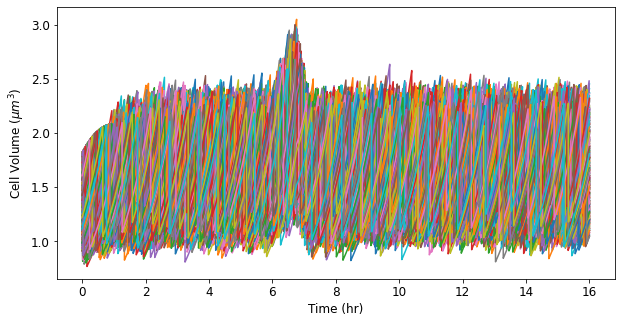

In [ ]:
simulation_min = 0
simulation_max = 16 # in hrs

iterations = 15000 # number of simulation points per replicate
replicates = 400 # number of replicate simulations

# concentration function
t_shift = 6
t_feast = 0.75
k_n0 = lambda t: (kn0_high - kn0_low) * (np.heaviside(t-t_shift,0.5) - np.heaviside(t-(t_shift+t_feast),0.5)) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2]) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration

V, V_0, t, delta_V, tau = SimulateAndPlot(simulation_max, iterations, replicates)

##### Simulation Analysis

Cleaning data to visualize $\Delta V$, $V_0$, and $\tau$

In [ ]:
# creating dataframes for time, tau, deltaV, and V_0
df_tau = pd.DataFrame(tau, columns=range(replicates))
df_deltaV = pd.DataFrame(delta_V, columns=range(replicates))
df_V0 = pd.DataFrame(V_0, columns=range(replicates))
df_time = pd.DataFrame(t, columns=['t'])

# joining tau, deltaV, and V_0 data with time
df_concatTau = pd.concat([df_time,df_tau], axis=1, join='inner')
df_concatDelta = pd.concat([df_time,df_deltaV], axis=1, join='inner')
df_concatV0 = pd.concat([df_time,df_V0], axis=1, join='inner')

Plotting $\tau$

In [ ]:
# Simulation

# removing zeros from tau data and appending into one column
tau_clean = pd.DataFrame(columns=['t','tau'])
for x in range(replicates):

    tau_cut = df_concatTau.loc[(df_concatTau[x] > 0), ['t',x]] # removing zeros
    tau_cut = tau_cut.rename(columns={x:'tau'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    tau_cut = tau_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    tau_clean = tau_clean.append(tau_cut).reset_index(drop=True) # appending and reindexing

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 # selecting time window for analysis
t_max = 16

time = np.linspace(t_min,t_max,n_bins+1)
tau_ave = np.zeros(len(time))
tau_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    tau_x = tau_clean.loc[(tau_clean['t'] > time[i]) & (tau_clean['t'] < time[i+1]), ['tau']]
    tau_ave[i] = np.mean(tau_x)
    tau_std[i] = np.std(tau_x)
    i+=1

# changing time range to match plot from paper
time075 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly
tau_ave075 = tau_ave[0:-1]
tau_std075 = tau_std[0:-1]

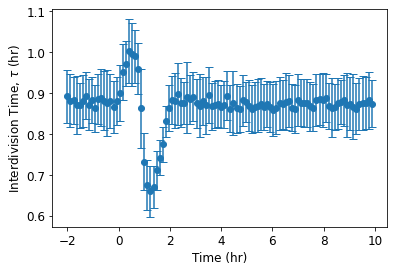

In [ ]:
plt.errorbar(time075, tau_ave075, yerr=tau_std075, fmt='o', capsize=4, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Interdivision Time, $\u03C4$ (hr)')
plt.show()

In [ ]:
# exporting to CSV
tau075 = pd.DataFrame(np.column_stack((time075,tau_ave075,tau_std075)), columns=['t','tau','std'])
# tau075.to_csv('Simulation Results/tau075.csv', index=False)

Plotting $\Delta$

In [ ]:
# removing zeros from deltaV data and appending into one column
deltaV_clean = pd.DataFrame(columns=['t','delta V'])
for x in range(replicates):

    delta_cut = df_concatDelta.loc[(df_concatDelta[x] > 0), ['t',x]] # removing zeros
    delta_cut = delta_cut.rename(columns={x:'delta V'}).reset_index(drop=True) # renaming column so data can be appended to existing 'delta V' column
    delta_cut = delta_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    deltaV_clean = deltaV_clean.append(delta_cut).reset_index(drop=True) # appending and reindexing

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 # selecting time window for analysis
t_max = 16

time = np.linspace(t_min,t_max,n_bins+1)
deltaV_ave = np.zeros(len(time))
deltaV_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    deltaV_x = deltaV_clean.loc[(deltaV_clean['t'] > time[i]) & (deltaV_clean['t'] < time[i+1]), ['delta V']]
    deltaV_ave[i] = np.mean(deltaV_x)
    deltaV_std[i] = np.std(deltaV_x)
    i+=1

# changing time range to match plot from paper
time075 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly

deltaV_ave075 = deltaV_ave[0:-1]
deltaV_std075 = deltaV_std[0:-1]

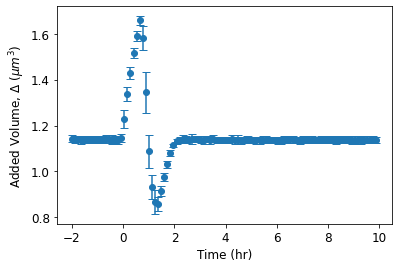

In [ ]:
plt.errorbar(time075, deltaV_ave075, yerr=deltaV_std075, fmt='o', capsize=4, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Added Volume, $\Delta$ ($\mu m^3$)')
plt.show()

In [ ]:
# exporting to CSV
deltaV075 = pd.DataFrame(np.column_stack((time075,deltaV_ave075,deltaV_std075)), columns=['t','deltaV','std'])
# deltaV075.to_csv('Simulation Results/deltaV075.csv', index=False)

Plotting $V_0$

In [ ]:
# removing zeros from tau data and appending into one column
V0_clean = pd.DataFrame(columns=['t','V_0'])
for x in range(replicates):

    V0_cut = df_concatV0.loc[(df_concatV0[x] > 0), ['t',x]] # removing zeros
    V0_cut = V0_cut.rename(columns={x:'V_0'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    V0_cut = V0_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    V0_cut = V0_cut.drop(len(V0_cut)) # remove last row because point has no corresponding deltaV
    V0_clean = V0_clean.append(V0_cut).reset_index(drop=True) # appending and reindexing

Plotting $\Delta V / V_0$

In [ ]:
# calculating deltaV / V0
V_ratio = pd.DataFrame(deltaV_clean['delta V'] / V0_clean['V_0'], columns=['V ratio']) # pairing previous timepoint V0 with current timepoint deltaV (matching corresponding birth and division datapoints)
Vratio_df = pd.concat([deltaV_clean['t'],V_ratio], axis=1, join='inner')

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4
t_max = 16

time = np.linspace(t_min,t_max,n_bins+1)
Vratio_ave = np.zeros(len(time))
Vratio_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    Vratio_i = Vratio_df.loc[(Vratio_df['t'] > time[i]) & (Vratio_df['t'] < time[i+1]), ['V ratio']]
    Vratio_ave[i] = np.mean(Vratio_i)
    Vratio_std[i] = np.std(Vratio_i)
    i+=1

# changing time range to match plot from paper
time075 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly

Vratio_ave075 = Vratio_ave[0:-1]
Vratio_std075 = Vratio_std[0:-1]

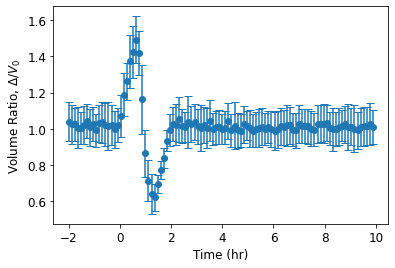

In [ ]:
plt.errorbar(time075, Vratio_ave075, yerr=Vratio_std075, fmt='o', capsize=4, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Volume Ratio, $\Delta / V_0$')
plt.show()

In [ ]:
# exporting to CSV
Vratio075 = pd.DataFrame(np.column_stack((time075,Vratio_ave075,Vratio_std075)), columns=['t','Vratio','std'])
# Vratio075.to_csv('Simulation Results/Vratio075.csv', index=False)

Figure 4B

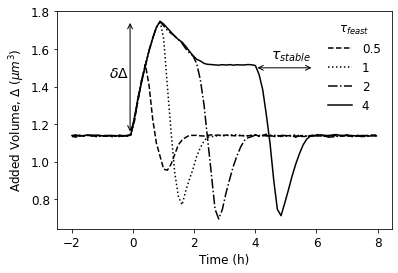

In [35]:
fig = plt.figure()
plt.rc('font', size=12) #controls default text size
lines = ['--',':','-.','-']

t_feast = [0.5,1,2,4]

i = 0
for x in t_feast:

    # reading in dataset
    if x == 0.1:
        df = pd.read_csv('Simulation Results/deltaV01.csv')
    elif x ==0.5:
        df = pd.read_csv('Simulation Results/deltaV05.csv')
    elif x == 0.75:
        df = pd.read_csv('Simulation Results/deltaV075.csv')
    elif x ==1.5:
        df = pd.read_csv('Simulation Results/deltaV15.csv')
    elif x ==1.75:
        df = pd.read_csv('Simulation Results/deltaV175.csv')
    else:
        df = pd.read_csv('Simulation Results/deltaV' + str(x) + '.csv')

    df = df.loc[(df['t'] < 8), ['t','deltaV']] # trimming dataset to specified time

    plt.plot(df['t'], df['deltaV'], color='k', linestyle=lines[i], label=x)
    i+=1
plt.xlabel('Time (h)')
plt.ylabel('Added Volume, $\Delta$ ($\mu m^3$)')
plt.legend(title='$\u03C4_{feast}$', frameon=False)

# plotting t_stable arrow
plt.annotate('$\u03C4_{stable}$', xy=(4.5,1.55), size=14)
plt.annotate("",
        xy=(4, 1.5), xycoords='data',
        xytext=(5.9, 1.5), textcoords='data',
        arrowprops=dict(arrowstyle="<->",
                        connectionstyle="arc3"),
        )

# plotting delta delta vol arrow
plt.annotate('$\delta \Delta$', xy=(-0.8,1.45), size=14)
plt.annotate("",
        xy=(-0.1, 1.15), xycoords='data',
        xytext=(-0.1, 1.75), textcoords='data',
        arrowprops=dict(arrowstyle="<->",
                        connectionstyle="arc3"),
        )
plt.show()

Figure 4E

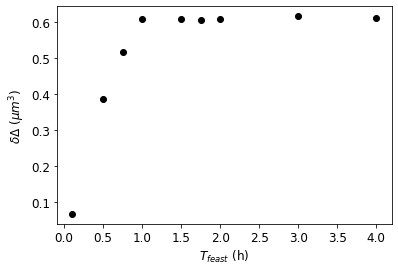

In [37]:
fig = plt.figure()
plt.rc('font', size=12) #controls default text size

t_feast = [0.1,0.5,0.75,1,1.5,1.75,2,3,4]

V_add = np.zeros(len(t_feast))
i = 0
for x in t_feast:

    # reading in dataset
    if x == 0.75:
        df = pd.read_csv('Simulation Results/deltaV075.csv')
    elif x ==0.1:
        df = pd.read_csv('Simulation Results/deltaV01.csv')
    elif x ==0.5:
        df = pd.read_csv('Simulation Results/deltaV05.csv')
    elif x ==1.5:
        df = pd.read_csv('Simulation Results/deltaV15.csv')
    elif x ==1.75:
        df = pd.read_csv('Simulation Results/deltaV175.csv')
    else:
        df = pd.read_csv('Simulation Results/deltaV' + str(x) + '.csv')

    V_add[i] = max(df['deltaV']) - df['deltaV'][0] # calculating stabilization time
    i+=1
plt.scatter(t_feast, V_add, color='k')
plt.xlabel('$T_{feast}$ (h)')
plt.ylabel('$\delta\Delta$ ($\mu m^3$)')
plt.show()

### Figure 4C

Defining Coupled ODEs

In [2]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**2) # regulatory function for k_n
f_prime = lambda a: -2*a/a_n**2 / (1 + (a/a_n)**2)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**2 / (1 + (a/a_t)**2) # regulatory function for k_t
g_prime = lambda a: 2*a/a_t**2 / (1 + (a/a_t)**2)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: (-f_prime(a)*g(a)*phiR_max + f(a)*g_prime(a)*phiR_min) / (-f_prime(a)*g(a) + f(a)*g_prime(a))

# f_X, fraction of cell synthesis capacity devoted to division protein production
f_X = lambda a: alpha*(phiR_max - f_R(a)) + beta

In [3]:
# defining growth rate function

def kappa(a, phi_R):

    k_t = k_t0 * g(a)

    k = k_t * (phi_R - phiR_min)
    return k

In [4]:
# ribosome mass fraction ODE (f_R variable)

def dphiR_dt(phi_R, t, a):

    k_t = k_t0 * g(a) # translational efficiency

    dpdt = k_t * (phi_R - phiR_min) * (f_R(a) - phi_R)
    return dpdt

In [5]:
def dXdt(X, t, a, phi_R, V):

    dxdt = f_X(a) * kappa(a, phi_R) * V - mu * X
    return dxdt

In [6]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R, tau):

    k_n = k_n0(t, tau) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - k_t * (phi_R - phiR_min)
    return dadt

In [7]:
def dVdt(V, t, a, phi_R):

    dvdt = kappa(a, phi_R) * V
    return dvdt

In [8]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, tau):

    phi_R,X,a,V = Species # Tuple unpakcing of each species, equivalent to phi_R = Species[0] // a = Species[1]

    phiR_ode = dphiR_dt(phi_R, t, a)
    X_ode = dXdt(X, t, a, phi_R, V)
    a_ode = dAAdt(a, t, phi_R, tau)
    V_ode = dVdt(V, t, a, phi_R)

    dSpeciesdt = [phiR_ode,X_ode,a_ode,V_ode]
    return dSpeciesdt

Defining functions to calculate steady state initial conditions

In [9]:
# function for phi_R at steady state

def phiR_ss(a, tau):
    
    k_n = k_n0(simulation_min, tau) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return (k_n*phiR_max + k_t*phiR_min) / (k_n + k_t)

In [10]:
# function for calculating steady state conditions for given parameters

def func(x, tau):
    return [phiR_ss(x[0], tau) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

Parameters

In [11]:
# parameters

phiR_min = 0.049 # Scott et al. 2010
phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

k_t0 = 2.6 # translational efficiency
kn0_high = 62.8 # nutritional efficiency, nutrient-rich
kn0_low = 5.29 # nutritional efficiency, nutrient-poor

alpha = 2.3 # f_X allocation parameters
beta = 0.7
mu = 0.6 # degradation rate

#### Simulating single cell trajectory

Simulation and Plot Functions

Making figure plot

In [12]:
# simulation implementation

def Simulate(simulation_max, iterations, tau):

    phi_R = np.zeros((iterations,1))
    phi_R[0] = phi_R0

    a = np.zeros((iterations,1))
    a[0] = a0

    X = np.zeros((iterations,1))
    X[0] = f_X(a0)*V0*0.2

    V = np.zeros((iterations,1))
    V[0] = V0

    t = np.linspace(simulation_min,simulation_max,iterations)

    i=1 # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
    while i < iterations:

        species_0 = [phi_R[i-1,0], X[i-1,0], a[i-1,0], V[i-1,0]] # packing initial conditions

        species = integrate.odeint(odes, species_0, t[i-1:i+1], args=(tau,)) # solving for values at next timestep

        phi_R[i], X[i], a[i], V[i] = species[1,:] # unpacking and storing species values for new time step

        X_0 = 1 # drawing random value for amount of division proteins required to trigger division
        # if cell has added threshold volume amount, it will then divide
        if X[i-1] >= X_0:
            r = np.random.normal(0.5, 0.04) # drawing random value for volume allocation to daughter cell, taken from normal distribution
            V[i] = r * V[i-1] # cell volume is divided roughly in half
            X[i] = 0 # division protein concentration is equally distributed between daughter cells

        i +=1

    return phi_R, X, a, V, t, tau

In [14]:
# plot function

def PlotFig(phi_R1, X1, a1, V1, Time1, tau1, phi_R2, X2, a2, V2, Time2, tau2):

    # Plot Layout
    fig, ax1 = plt.subplots(5,1, figsize=(8,9))
    plt.rc('font', size=14) #controls default text size
    gs = gridspec.GridSpec(5,1, height_ratios=[1,1,1,1.5,1.5])
    plt.xlabel('Time (h)')

    # Plot 1
    ax0 = plt.subplot(gs[0])
    ax0.plot(Time1, k_n0(Time1, tau1), color='g', linestyle='--')
    ax0.plot(Time2, k_n0(Time2, tau2), color='g')
    ax0.set_ylabel('Nutrient Conc.', color='g')
    ax0.set_yticks([])
    ax0.set_yticklabels([])
    ax0.annotate('$\u03C4_{feast}=0.75$ h', xy=(0.8,45), size=14)
    ax0.annotate('$\u03C4_{feast}=4$ h', xy=(4.05,45), size=14)
    ax0.set_ylim(-10,80)

    # Plot 2
    ax0 = plt.subplot(gs[1])
    ax0.plot(Time1, kappa(a1, phi_R1), color='k', linestyle='--')
    ax0.plot(Time2, kappa(a2, phi_R2), color='k')
    ax0.set_ylabel('$\kappa$ (h$^{-1}$)')

    # Plot 2
    ax1 = plt.subplot(gs[2])
    ax1.set_ylabel('$f_X$')
    ax1.plot(Time1, f_X(a1)/250, color='k', linestyle='--')
    ax1.plot(Time2, f_X(a2)/250, color='k')

    # Plot 3
    ax2 = plt.subplot(gs[3])
    ax2.set_ylabel('$k_P$ $(h^{-1}\mu m^{-3})$', color='tab:blue')
    # removing timepoints which are artifacts from simulation
    kP = f_X(a1)*kappa(a1, phi_R1)
    t_step = (simulation_max - simulation_min) / iterations
    index = np.where((Time1 > t_shift + tau1) & (Time1 < t_shift + tau1 + 50*t_step)) # removing the 50 timesteps after shift (adjust value based on total number of timesteps)
    kP_adj = np.delete(kP, index)
    t_adj = np.delete(Time1, index)
    ax2.plot(t_adj, kP_adj, color='tab:blue', linestyle='--')

    kP = f_X(a2)*kappa(a2, phi_R2)
    t_step = (simulation_max - simulation_min) / iterations
    index = np.where((Time2 > t_shift + tau2) & (Time2 < t_shift + tau2 + 50*t_step)) # removing the 50 timesteps after shift (adjust value based on total number of timesteps)
    kP_adj = np.delete(kP, index)
    t_adj = np.delete(Time2, index)
    ax2.plot(t_adj, kP_adj, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(0.2,1.27)

    # Plot 4
    ax3 = plt.subplot(gs[4])
    ax3.set_ylabel('$\u03C4$ (h)')
    df = pd.read_csv('Simulation Results/tau075.csv')
    ax3.plot(df['t'], df['tau'], color='k', linestyle='--')
    df = pd.read_csv('Simulation Results/tau4.csv')
    ax3.plot(df['t'], df['tau'], color='k')
    ax3.set_xlabel('Time (h)')
    ax3.set_xlim(-2.4,6.3)

    plt.subplots_adjust(hspace=.0)

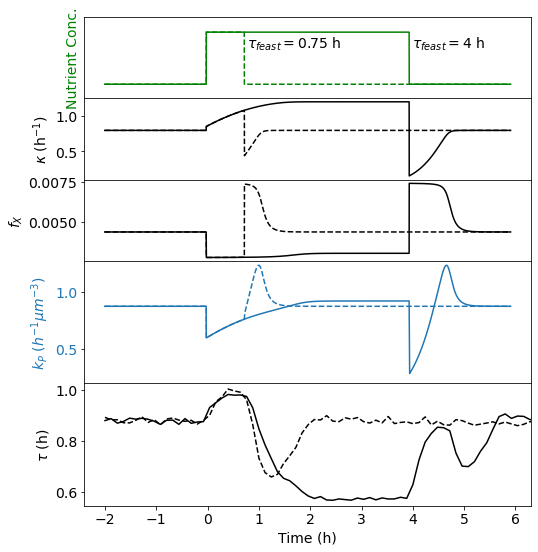

In [16]:
simulation_min = -2
simulation_max = 6 # in hrs
iterations = 40000 #number of simulation points

t_shift = 0 # time at which nutrient shift occurs, in hrs
tau = [0.75, 4]
k_n0 = lambda t, tau: (kn0_high - kn0_low) * (np.heaviside(t-t_shift,0.5) - np.heaviside(t-(t_shift+tau),0.5)) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2], args=(tau[0])) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration
V0 = 1.5 # initial cell volume, in um^3

phi_R1, X1, a1, V1, Time1, tau1 = Simulate(simulation_max, iterations, tau[0])
phi_R2, X2, a2, V2, Time2, tau2 = Simulate(simulation_max, iterations, tau[1])
PlotFig(phi_R1, X1, a1, V1, Time1, tau1, phi_R2, X2, a2, V2, Time2, tau2)